In [246]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib

# Exploratory Data Analysis for AQI dataset

This dataset contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. This dataset was taken from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/index.php

## Content
The dataset contains 9357 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year) representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.

We should use this for creating our Descentralized AQI Classifier solution.

## Loading the dataset

In [247]:
train_csv = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6__hHU1bGI7oczcrZifx8gFp23DXMQLVu6o_7AgPhh0fwCyH8XhWR0IbZgoT26SAmnQZH9rYsU-xc/pub?gid=1720806244&single=true&output=csv"
data = pd.read_csv(train_csv)

First , we should investigate the whole dataset, the kinds of data, null values and so on. Data info is a good function for that.

In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           9357 non-null   object
 1   Time           9357 non-null   object
 2   CO(GT)         9357 non-null   object
 3   PT08.S1(CO)    9357 non-null   int64 
 4   NMHC(GT)       9357 non-null   int64 
 5   C6H6(GT)       9357 non-null   object
 6   PT08.S2(NMHC)  9357 non-null   int64 
 7   NOx(GT)        9357 non-null   int64 
 8   PT08.S3(NOx)   9357 non-null   int64 
 9   NO2(GT)        9357 non-null   int64 
 10  PT08.S4(NO2)   9357 non-null   int64 
 11  PT08.S5(O3)    9357 non-null   int64 
 12  T              9357 non-null   object
 13  RH             9357 non-null   object
 14  AH             9357 non-null   object
dtypes: int64(8), object(7)
memory usage: 1.1+ MB


We have to turn the columns from object to float, to be easier to do the calculations.

In [249]:
# Converter colunas numéricas para float
numerical_columns = [
    'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
]

for column in numerical_columns:
    data[column] = pd.to_numeric(data[column].astype(str).str.replace(',', '.'), errors='coerce')

# Verificar as primeiras linhas do DataFrame para garantir que as conversões foram bem-sucedidas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [250]:
data.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


We see above that we have a lot of -200 values. -200 is a standard notation for invalid value. So we have to solve this.

In [251]:
data.replace(-200, pd.NA, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           9357 non-null   object
 1   Time           9357 non-null   object
 2   CO(GT)         7674 non-null   object
 3   PT08.S1(CO)    8991 non-null   object
 4   NMHC(GT)       914 non-null    object
 5   C6H6(GT)       8991 non-null   object
 6   PT08.S2(NMHC)  8991 non-null   object
 7   NOx(GT)        7718 non-null   object
 8   PT08.S3(NOx)   8991 non-null   object
 9   NO2(GT)        7715 non-null   object
 10  PT08.S4(NO2)   8991 non-null   object
 11  PT08.S5(O3)    8991 non-null   object
 12  T              8991 non-null   object
 13  RH             8991 non-null   object
 14  AH             8991 non-null   object
dtypes: object(15)
memory usage: 1.1+ MB


Seeing above, We can remove from the study the non numerical data and NMHC(GT) , which have more than 90% of missing values.

In [252]:
data = data.drop(columns=['Date', 'Time', 'NMHC(GT)'])
data.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.0,8991,8991.0,8991,7718,8991,7715,8991,8991,8991.0,8991.0,8991.0000
unique,96.0,1041,407.0,1245,925,1221,283,1603,1743,436.0,753.0,6683.0000
top,1.0,973,3.6,853,89,767,97,1488,825,20.8,53.1,0.7487
freq,305.0,30,84.0,25,41,25,78,24,20,57.0,31.0,6.0000


We still have the NaN values to remove, but it is easier now that we converted from -200.

In [253]:
data = data.dropna()
data.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6941.0,6941,6941.0,6941,6941,6941,6941,6941,6941,6941.0,6941.0,6941.0000
unique,94.0,1016,392.0,1189,896,1129,274,1543,1693,428.0,742.0,5460.0000
top,1.0,973,3.6,880,89,733,110,1488,836,12.0,47.8,0.7487
freq,269.0,24,65.0,20,35,20,72,18,18,44.0,24.0,6.0000


## Variable distributions

Visual distributions can help us to visualize the value distribution through the variables in the dataset before creating the model. So, lets get started we histograms of all the numerical values.

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


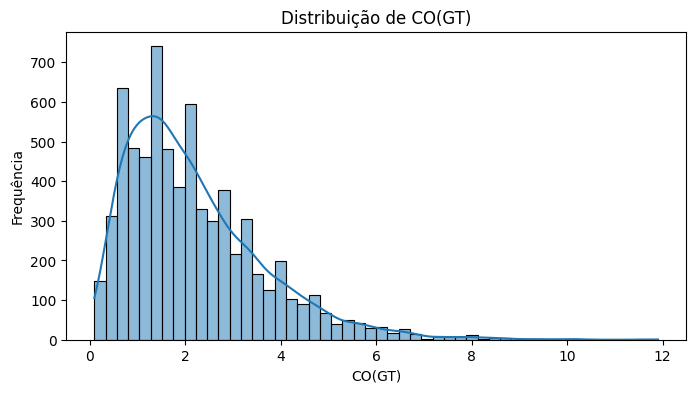

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


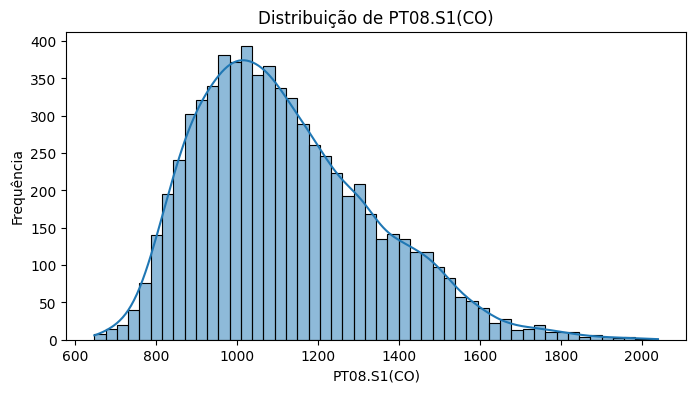

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


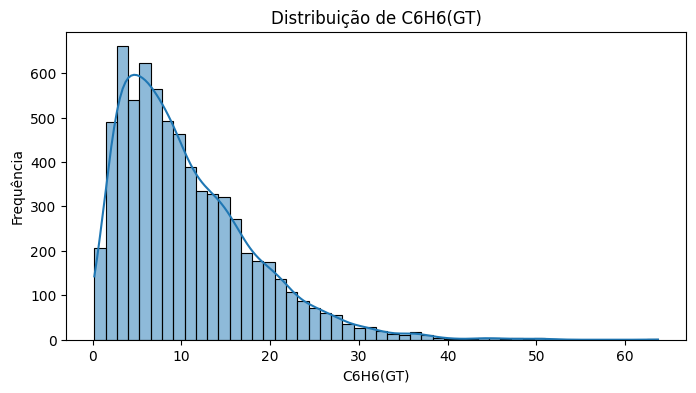

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


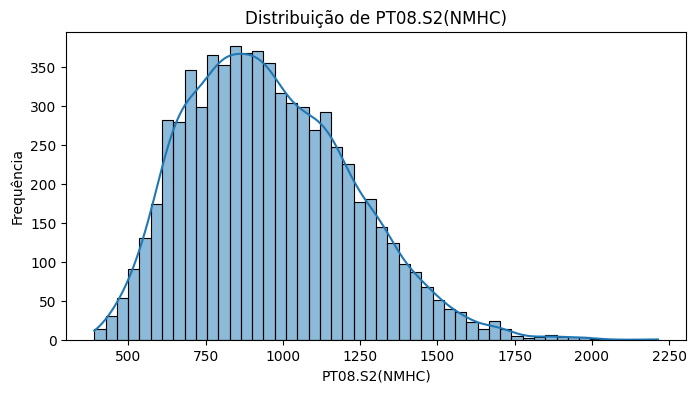

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


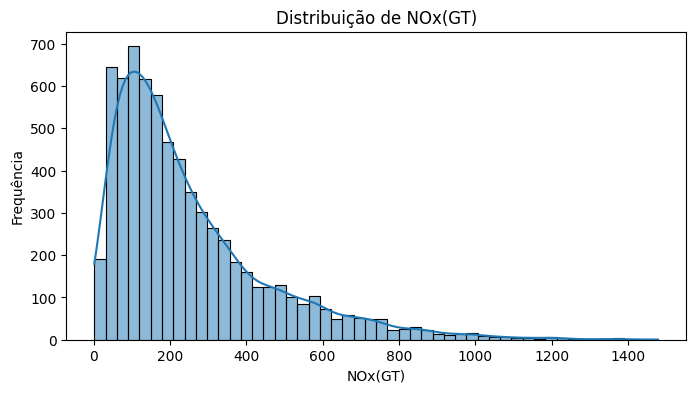

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


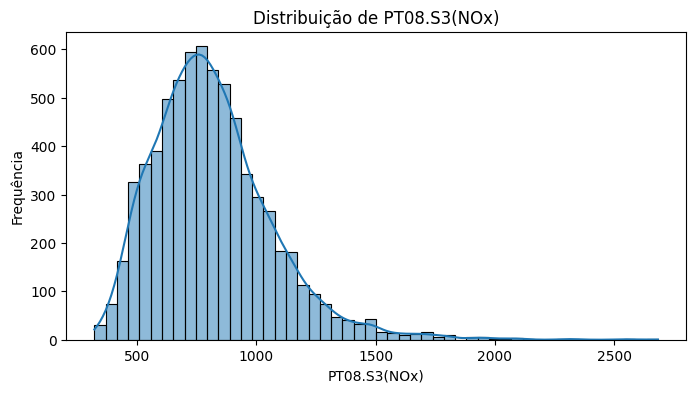

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


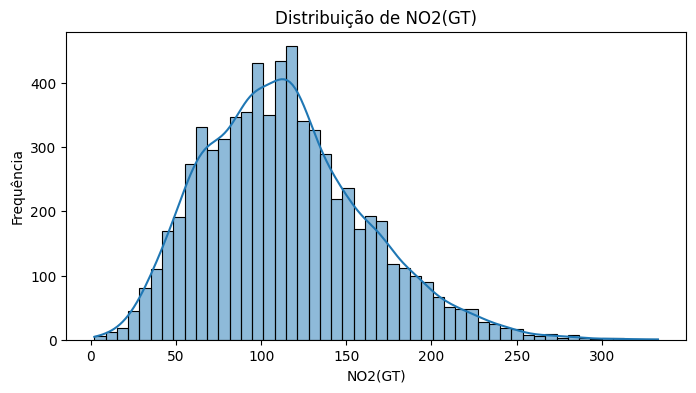

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


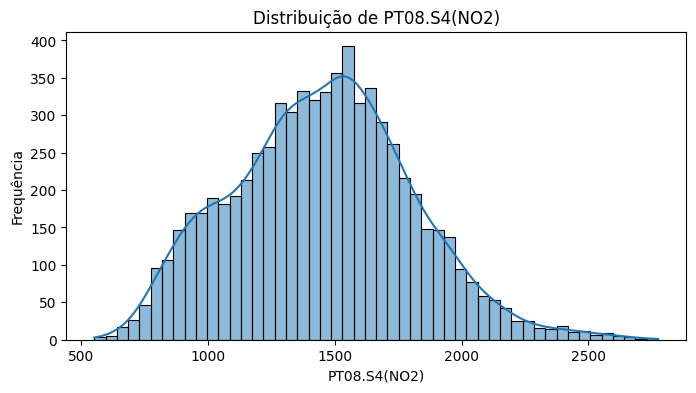

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


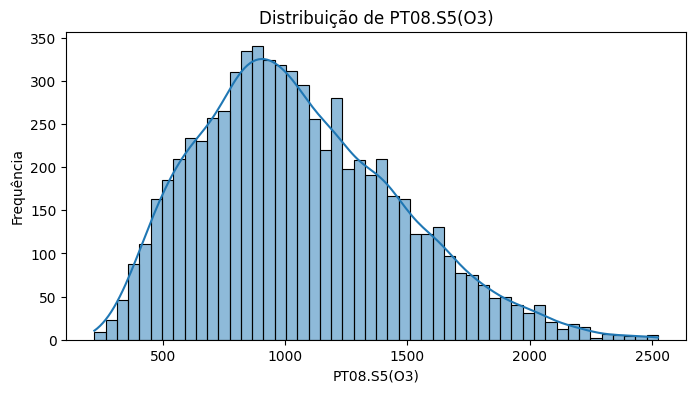

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


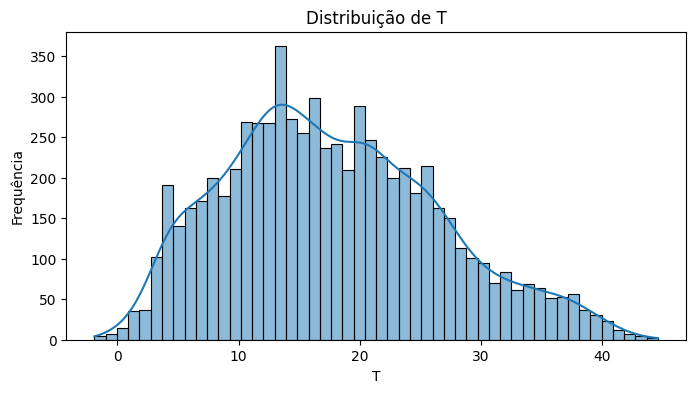

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


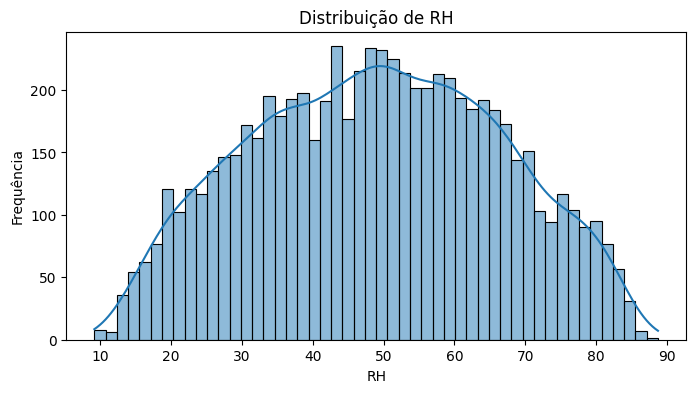

C:\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


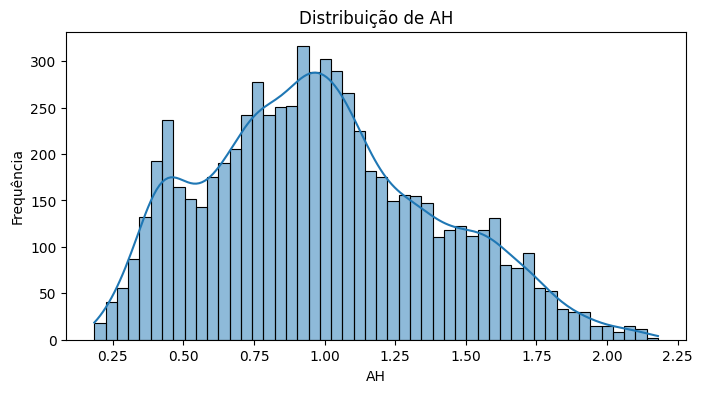

In [254]:
for column in data:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=50)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()

Boxplots are a powerfull way to visualize if we have outliers in our study and what to do with them.

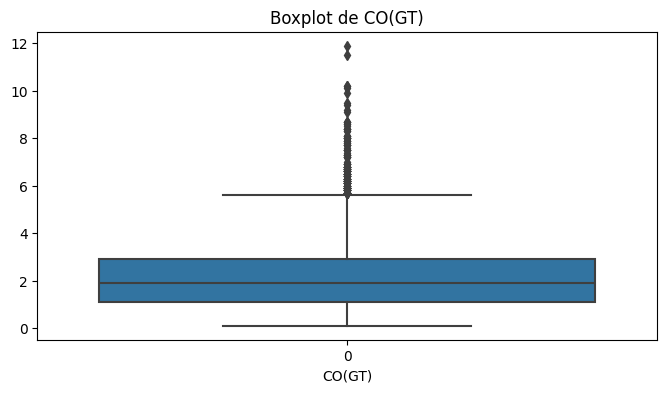

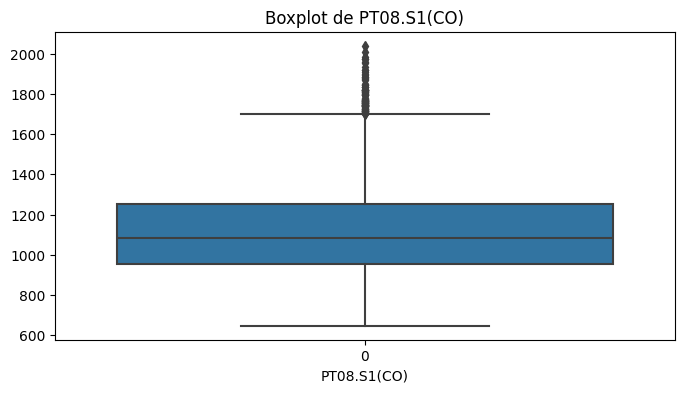

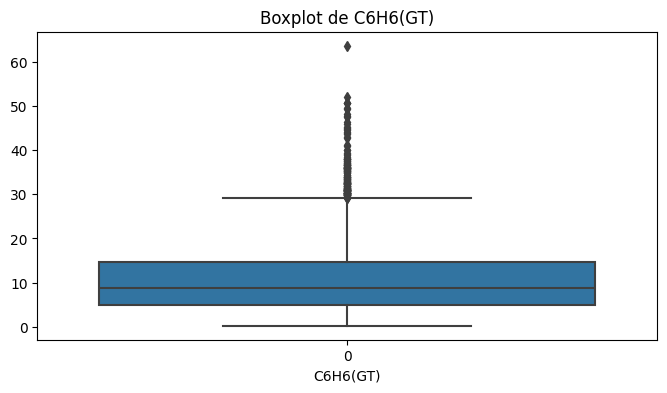

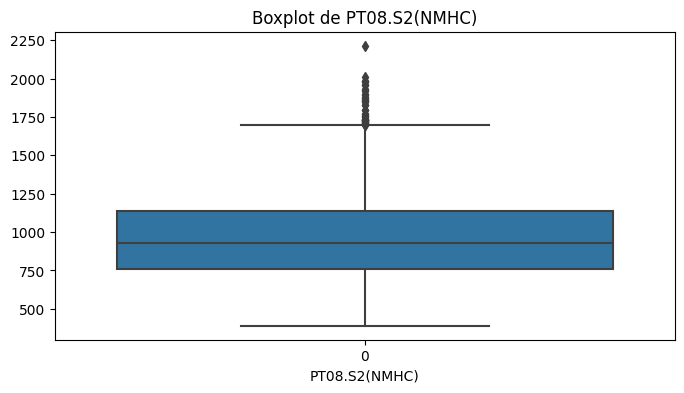

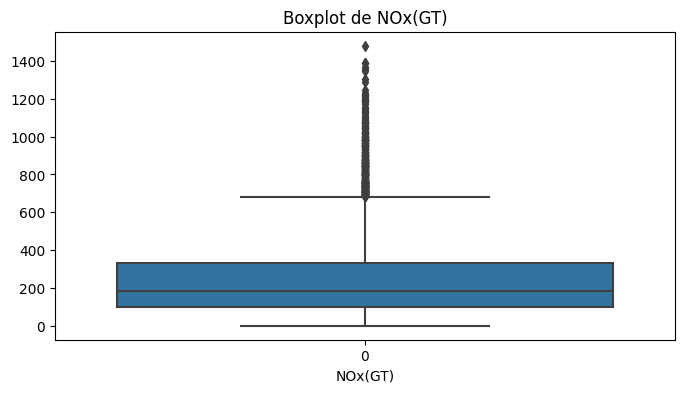

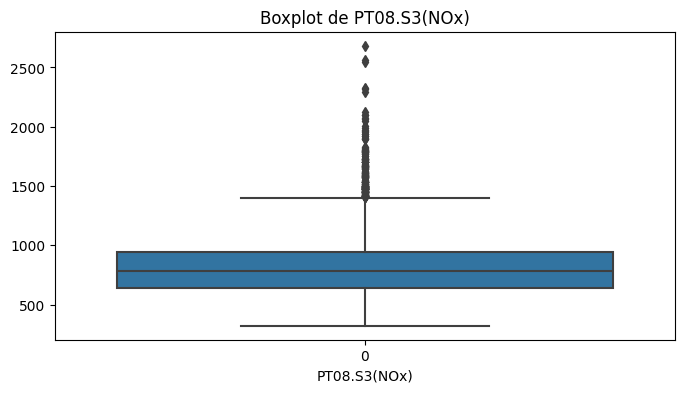

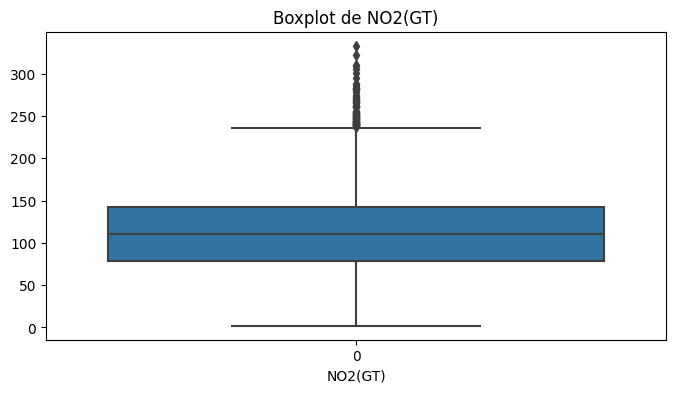

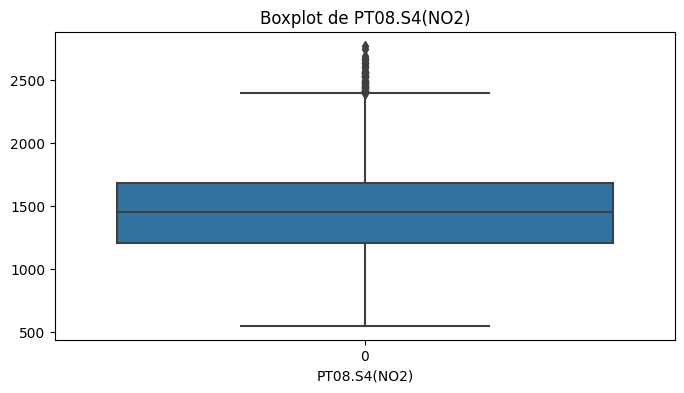

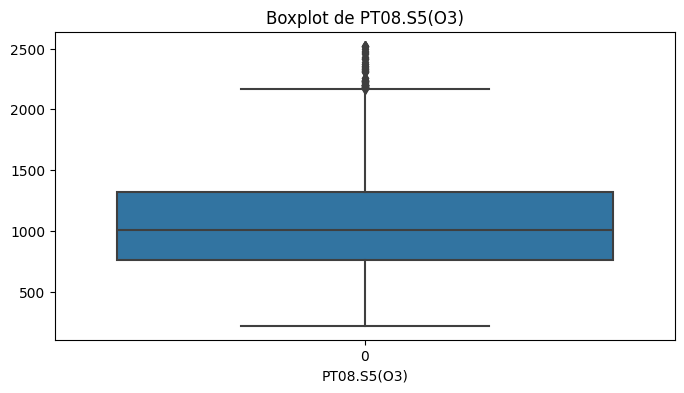

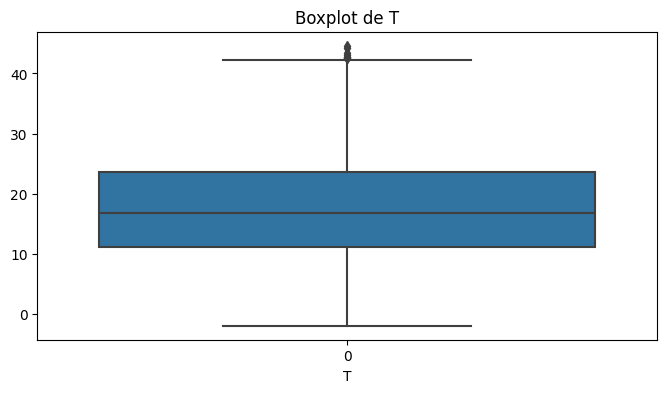

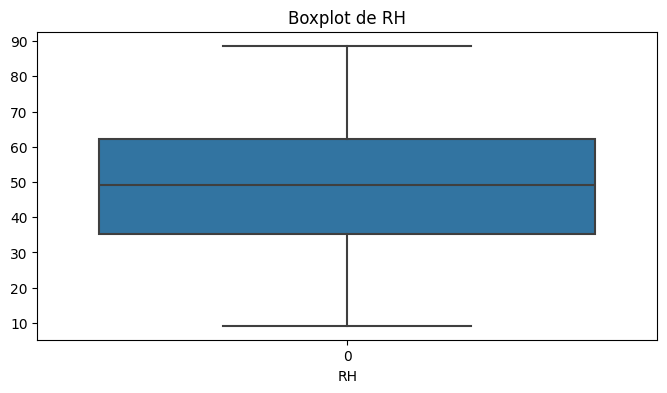

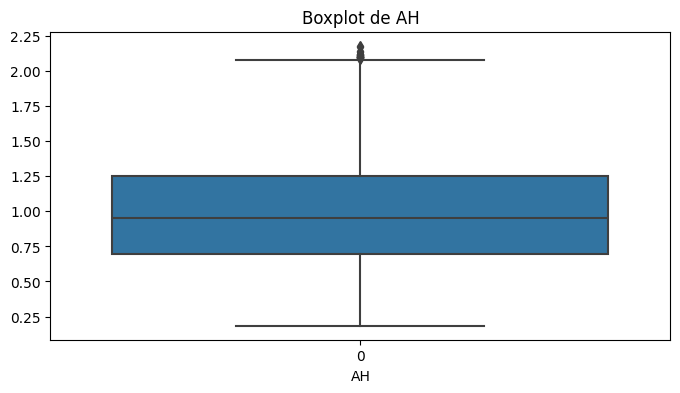

In [255]:
for column in data:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
    plt.show()

We can choose to leave the outliers in, or remove than based on how far they are from the quartiles. Lets remove them and plot an before and after comparison:

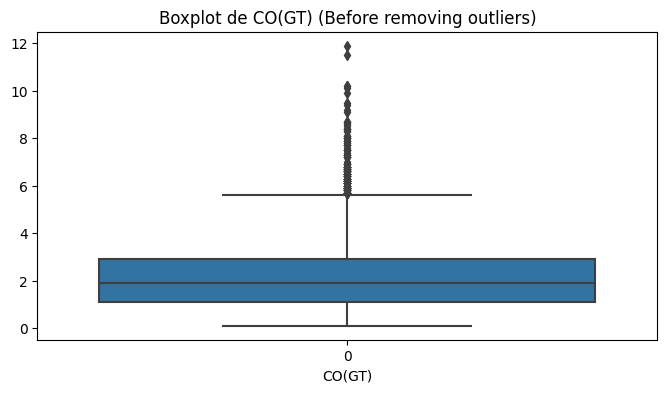

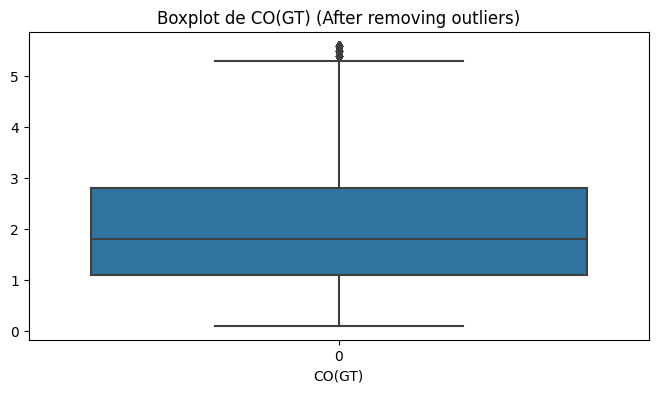

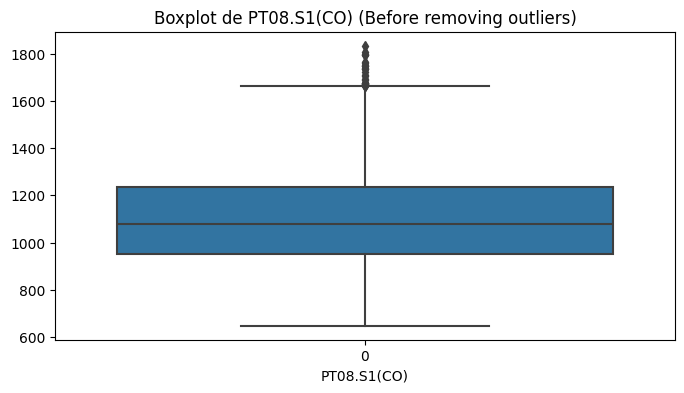

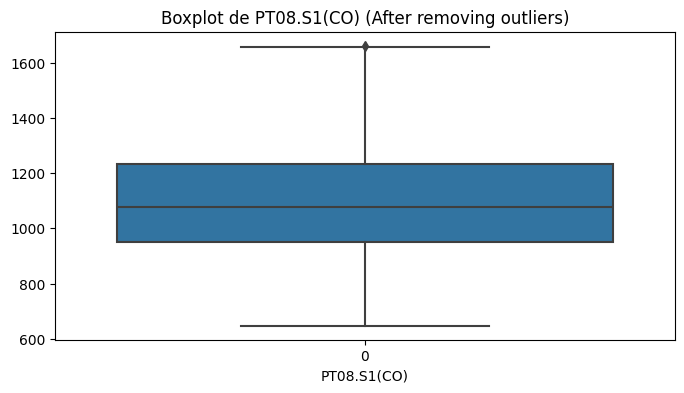

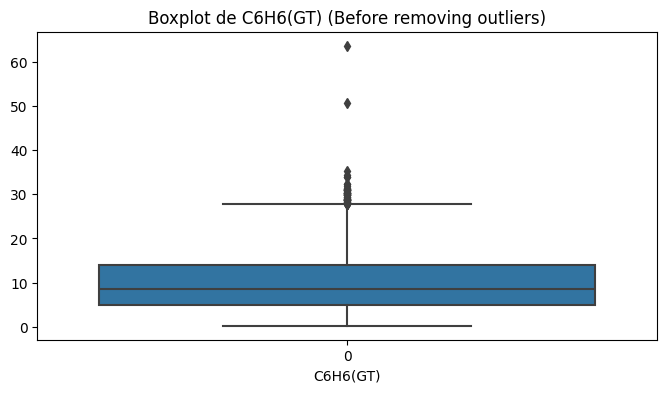

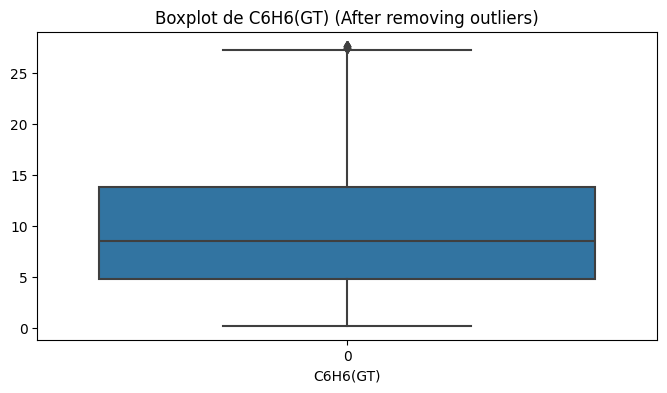

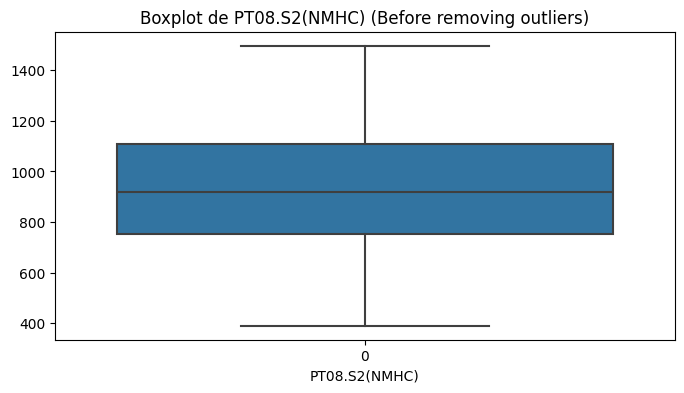

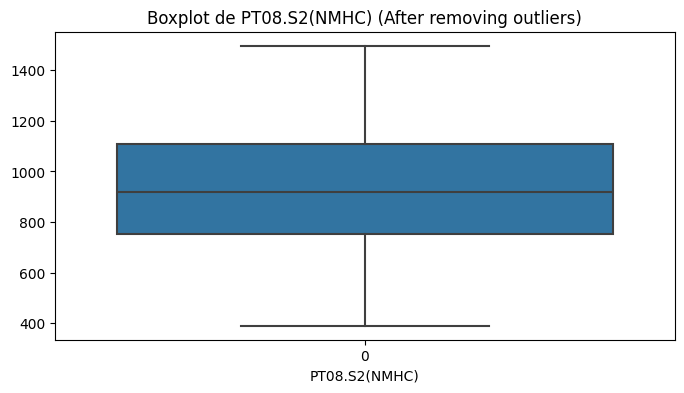

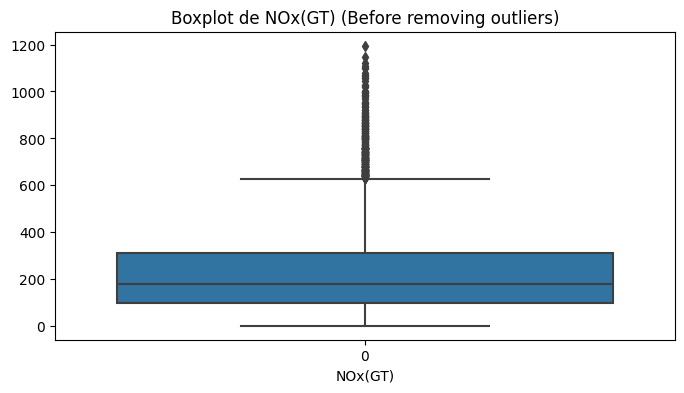

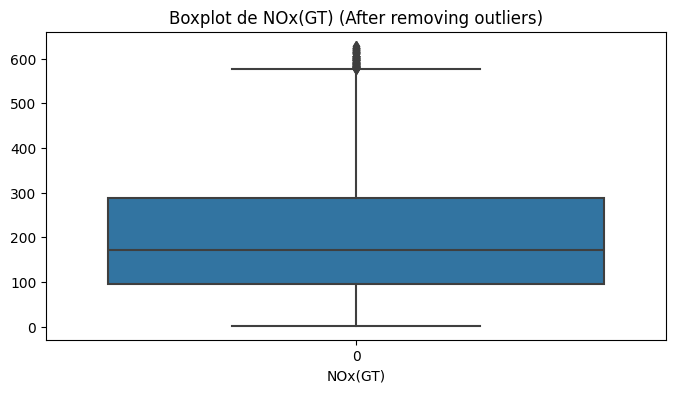

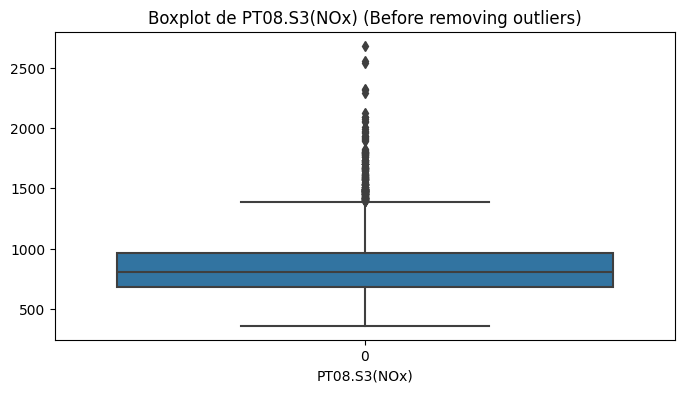

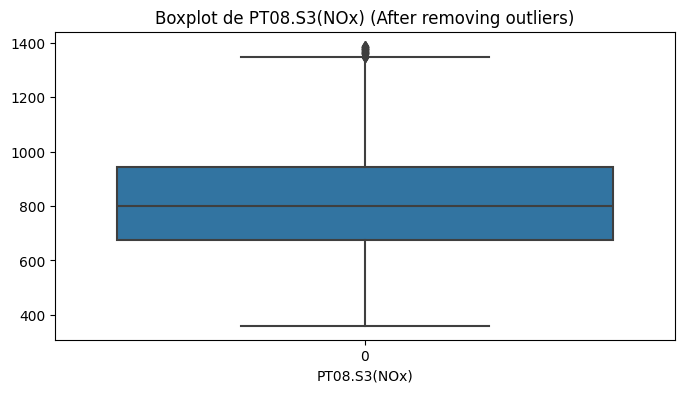

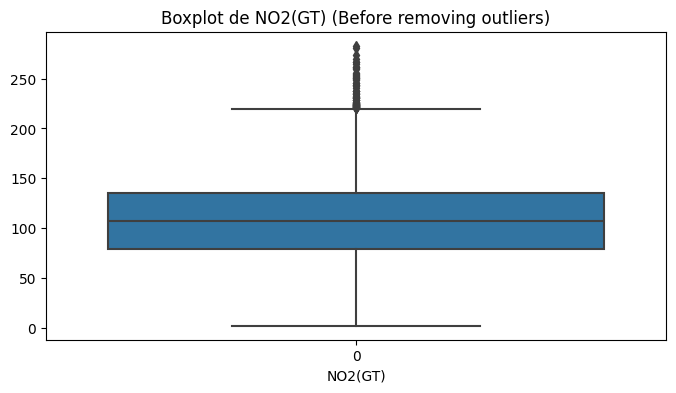

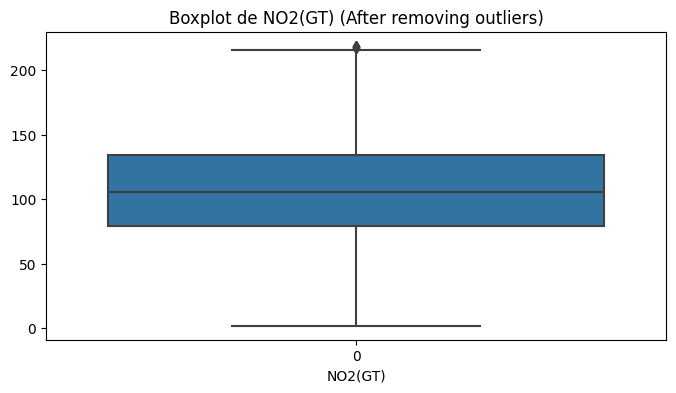

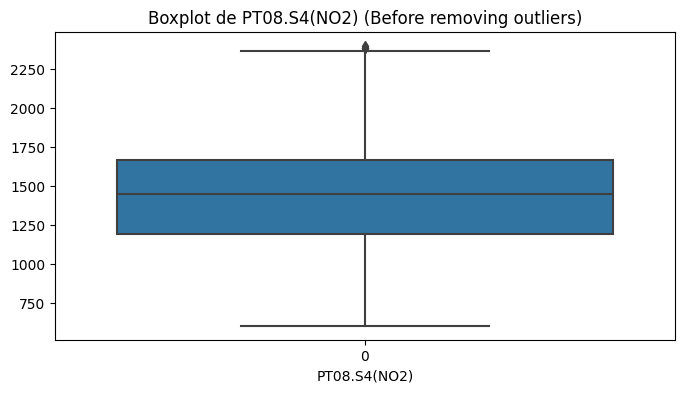

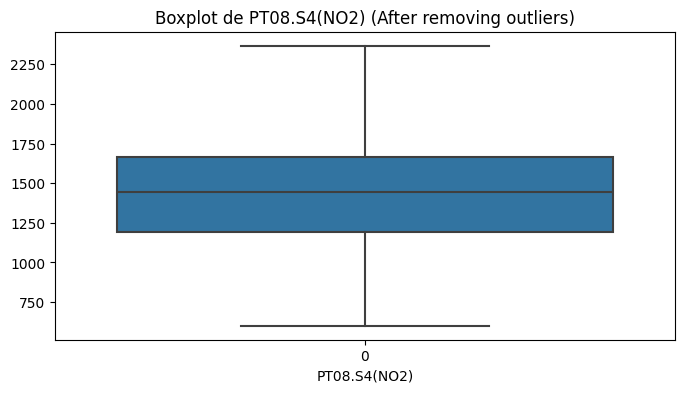

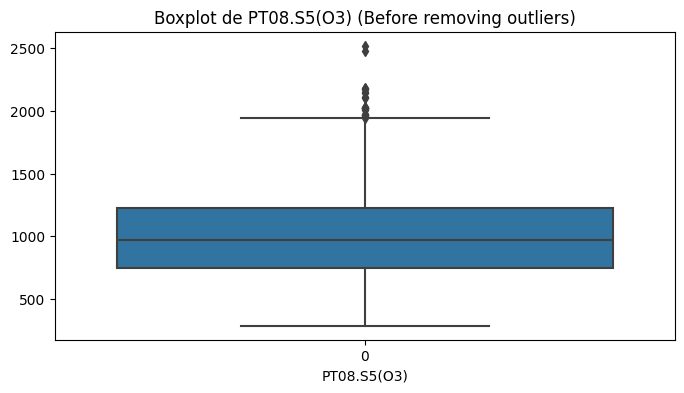

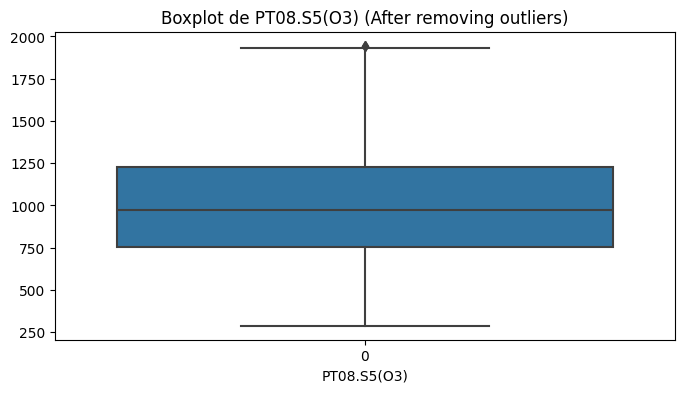

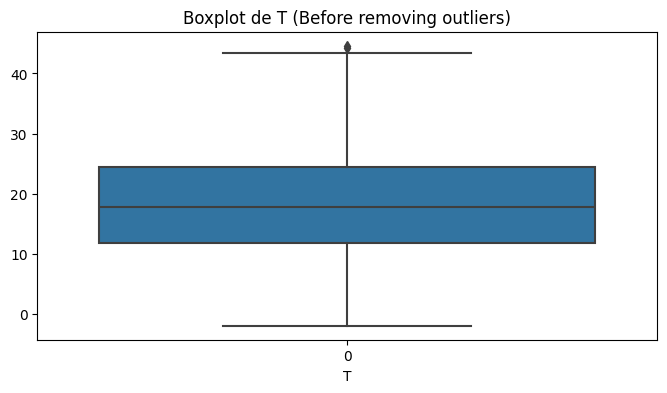

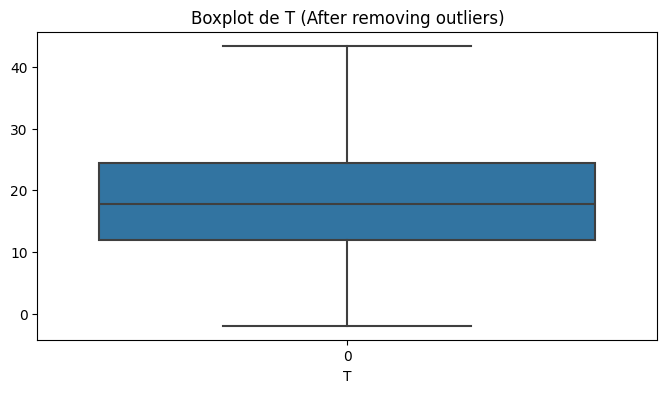

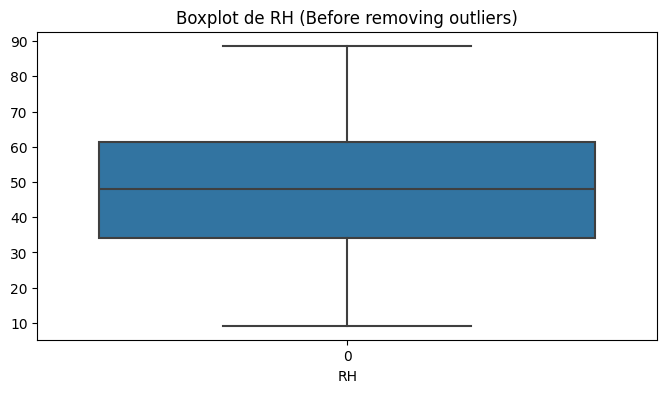

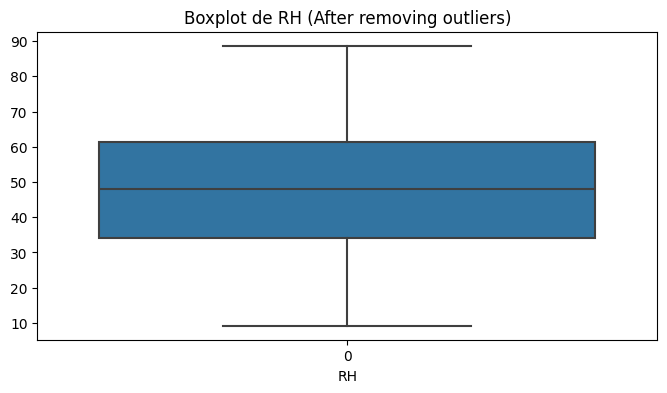

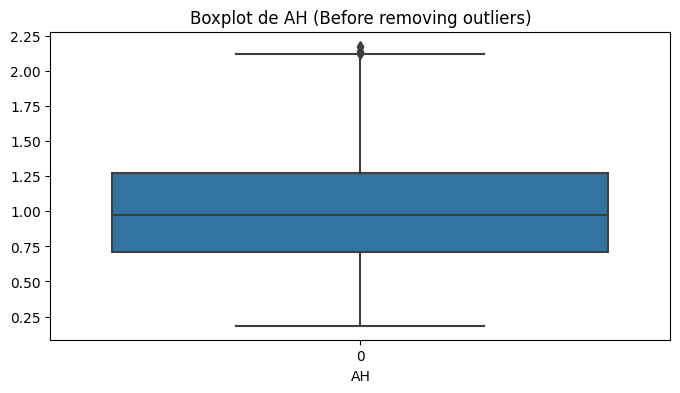

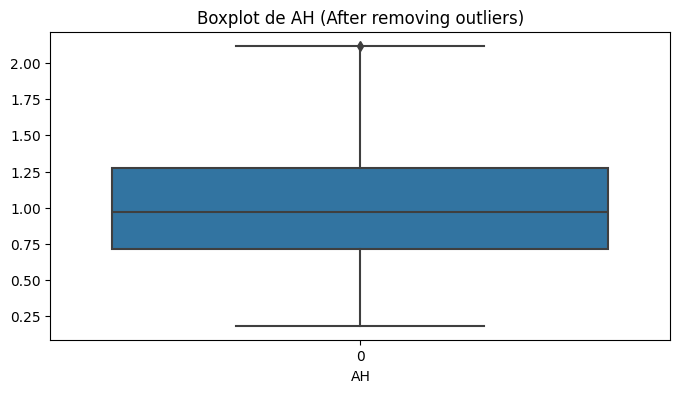

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    return df[(df[column_name] >= lower_limit) & (df[column_name] <= upper_limit)]

data_cleaned = data.copy()

for column in data:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_cleaned[column])
    plt.title(f'Boxplot de {column} (Before removing outliers)')
    plt.xlabel(column)
    plt.show()
    
    data_cleaned = remove_outliers(data_cleaned, column)
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(data_cleaned[column])
    plt.title(f'Boxplot de {column} (After removing outliers)')
    plt.xlabel(column)
    plt.show()


We can see below that we have a cleaner dataset

In [257]:
data_cleaned.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6084.0,6084,6084.0,6084,6084,6084,6084,6084,6084,6084.0,6084.0,6084.0000
unique,56.0,836,271.0,972,608,909,211,1405,1366,425.0,740.0,4944.0000
top,1.0,973,3.6,880,89,733,95,1418,836,21.3,47.8,0.8736
freq,261.0,24,62.0,20,35,20,69,15,18,42.0,21.0,5.0000


Heatmaps are useful to discorver relationships between variables. So lets plot one.

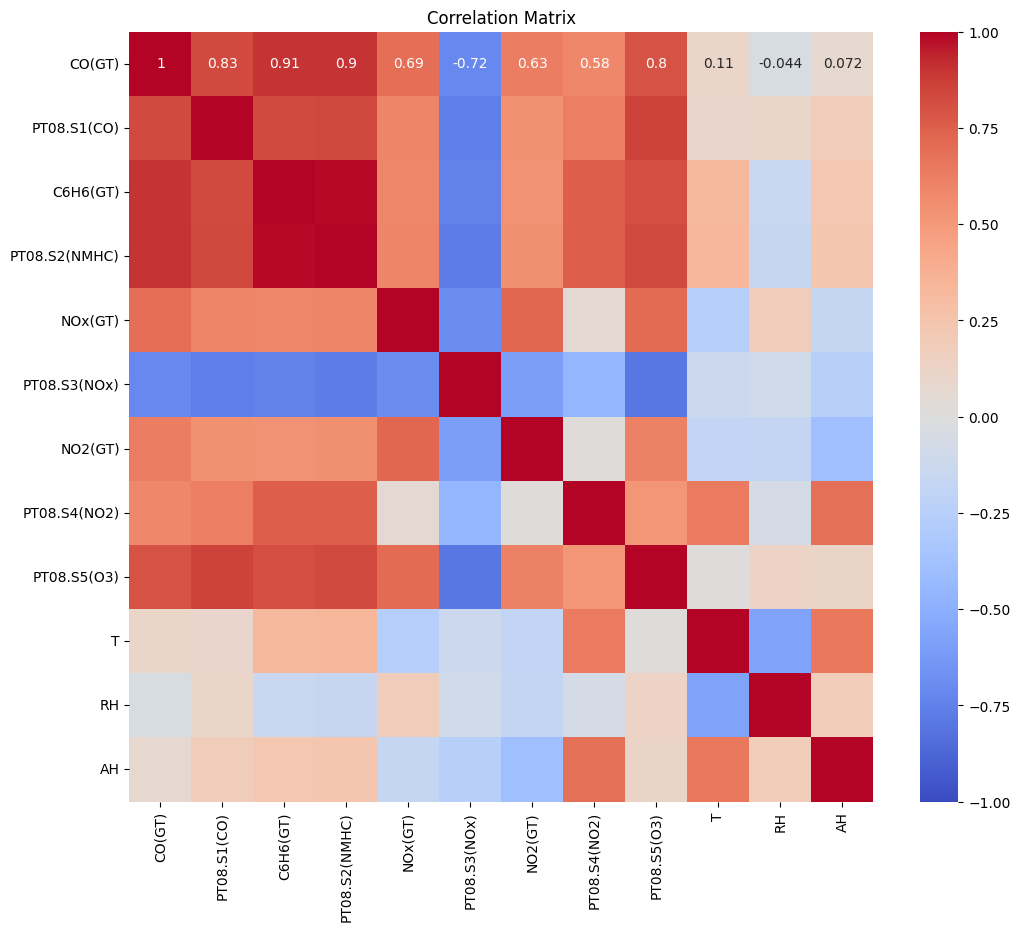

In [258]:
correlation_matrix = data_cleaned[data_cleaned.columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

## Training the model

With the cleaning steps ready, we can start thinking on how we can train this dataset to generate a model for our solution.  The reference variables will be the groundtruths for CO, NOx and NO2, and we remove all the Grountruths from the training set.

In [259]:
X = data_cleaned.drop(['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)
y = data_cleaned[['CO(GT)','NOx(GT)', 'NO2(GT)']]  # Variáveis GT como referência

X.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,1360,1046,1056,1692,1268,13.6,48.9,0.7578
1,1292,955,1174,1559,972,13.3,47.7,0.7255
2,1402,939,1140,1555,1074,11.9,54.0,0.7502
3,1376,948,1092,1584,1203,11.0,60.0,0.7867
4,1272,836,1205,1490,1110,11.2,59.6,0.7888


In [260]:
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The goal is to predict continuous values (pollutant concentrations), which is intrinsically a regression problem. Linear Regression is one of the most fundamental techniques for regression problems. Also, Linear Regression is simple, easy to implement and interpret. You can easily understand the relationship between the independent and dependent variables by looking at the model coefficients.So, lets go with LR for this sample.

In [261]:
# Treinar modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Based on pollutant predictions, we can calculate an air quality index (AQI) and categorize this AQI into different levels. Just for the sake of simplicity, we will just calculate the mean of all values predicted by our model.

In [262]:
#We define a simple AQI function
def calculate_aqi(concentrations):
    aqi = concentrations.mean(axis=1)
    return aqi

#We define here a simple categorize function based on the international range

def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Bad for sensible groups'
    elif aqi <= 200:
        return 'Bad'
    elif aqi <= 300:
        return 'Very bad'
    else:
        return 'Dangerous'

No we can use the model to predict the test values. And we can still calculate metrics such as MSE.

In [263]:
# Prever concentrações de poluentes
predicted_concentrations = model.predict(X_test)

# Calcular AQI a partir de previsões de poluentes
predicted_aqi = calculate_aqi(pd.DataFrame(predicted_concentrations, columns=['CO(GT)','NOx(GT)', 'NO2(GT)']))

# Avaliar o modelo (opcional)
mse = mean_squared_error(y_test, predicted_concentrations)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1167.3460143391228


Finally, we can give the model some inputs for testing it:

In [264]:
user_input = {
    'PT08.S1(CO)': 1360,
    'PT08.S2(NMHC)': 1046,
    'PT08.S3(NOx)': 1056,
    'PT08.S4(NO2)': 1692,
    'PT08.S5(O3)': 1268,
    'T': 21.6,
    'RH': 13.6,
    'AH': 0.76
}

good_air_quality_input = {
    'PT08.S1(CO)': 700,  # Supondo baixas concentrações de monóxido de carbono
    'PT08.S2(NMHC)': 400,
    'PT08.S3(NOx)': 1450,
    'PT08.S4(NO2)': 900,
    'PT08.S5(O3)': 500,  # Supondo baixas concentrações de ozônio
    'T': 20.0,          # Temperatura em graus Celsius
    'RH': 50.0,         # Umidade relativa em percentagem
    'AH': 0.8           # Concentração absoluta de umidade
}

# Exemplo de entrada para qualidade do ar ruim
bad_air_quality_input = {
    'PT08.S1(CO)': 1500,
    'PT08.S2(NMHC)': 1100,
    'PT08.S3(NOx)': 850,
    'PT08.S4(NO2)': 1700,
    'PT08.S5(O3)': 1400,
    'T': 30.0,
    'RH': 70.0,
    'AH': 1.3
}

# Exemplo de entrada para qualidade do ar muito ruim
very_bad_air_quality_input = {
    'PT08.S1(CO)': 2000,
    'PT08.S2(NMHC)': 1500,
    'PT08.S3(NOx)': 550,
    'PT08.S4(NO2)': 2200,
    'PT08.S5(O3)': 2200,
    'T': 35.0,
    'RH': 80.0,
    'AH': 1.8
}

# Converte o input do usuário em um DataFrame
user_input_df = pd.DataFrame([user_input])
user_input_gd = pd.DataFrame([good_air_quality_input])
user_input_bd = pd.DataFrame([bad_air_quality_input])
user_input_vb = pd.DataFrame([very_bad_air_quality_input])

# Agora você pode usar o modelo para fazer previsões com esse input
user_predicted_concentrations = model.predict(user_input_df)
user_predicted_aqi = calculate_aqi(pd.DataFrame(user_predicted_concentrations, columns=['CO(GT)','NOx(GT)', 'NO2(GT)']))

# Agora você pode usar o modelo para fazer previsões com esse input
user_predicted_concentrations_good = model.predict(user_input_gd)
user_predicted_aqi_good = calculate_aqi(pd.DataFrame(user_predicted_concentrations_good, columns=['CO(GT)','NOx(GT)', 'NO2(GT)']))

# Agora você pode usar o modelo para fazer previsões com esse input
user_predicted_concentrations_bad = model.predict(user_input_bd)
user_predicted_aqi_bad = calculate_aqi(pd.DataFrame(user_predicted_concentrations_bad, columns=['CO(GT)','NOx(GT)', 'NO2(GT)']))

# Agora você pode usar o modelo para fazer previsões com esse input
user_predicted_concentrations_vb = model.predict(user_input_vb)
user_predicted_aqi_vb = calculate_aqi(pd.DataFrame(user_predicted_concentrations_vb, columns=['CO(GT)','NOx(GT)', 'NO2(GT)']))

print(f'Predicted AQI for user input: {categorize_aqi(user_predicted_aqi.values[0])}')
print(f'Predicted AQI for user input good: {categorize_aqi(user_predicted_aqi_good.values[0])}')
print(f'Predicted AQI for user input bad: {categorize_aqi(user_predicted_aqi_bad.values[0])}')
print(f'Predicted AQI for user input very bad: {categorize_aqi(user_predicted_aqi_vb.values[0])}')


Predicted AQI for user input: Moderate
Predicted AQI for user input good: Good
Predicted AQI for user input bad: Bad
Predicted AQI for user input very bad: Very bad


This model could be more refined and some aspects of the AQI calculation could be defined a more refined equation, but for the sake of this project this if enough for now.

In [235]:
model_to_python

'def score(input):\n    return [-3.4314828277812492 + input[0] * 0.0014516206277804915 + input[1] * 0.005075837567655176 + input[2] * 0.0006555328754626814 + input[3] * -0.0006578112851300627 + input[4] * -0.0002605932569195277 + input[5] * -0.022905391597949274 + input[6] * -0.0011586139575799576 + input[7] * 0.22712234311017132, -250.31335155309625 + input[0] * 0.06348633189274375 + input[1] * 0.9051302461659242 + input[2] * 0.06320219915996506 + input[3] * -0.5557654363756814 + input[4] * 0.06503598719530879 + input[5] * 1.2919762298198085 + input[6] * 2.366836615985157 + input[7] * 93.72469182538268, 169.46360947791646 + input[0] * 0.02697855672428252 + input[1] * 0.06771216873450446 + input[2] * -0.07600763562574586 + input[3] * -0.040690700992426596 + input[4] * 0.015164302207881918 + input[5] * 0.12611925496397935 + input[6] * -0.260233750583304 + input[7] * -37.33974950765017]'